In [29]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import BlockRNNModel

In [2]:
mapa_meses = {'jan':1,'fev':2,'mar':3,'abr':4,'mai':5,'jun':6,'jul':7,'ago':8,'set':9,'out':10,'nov':11,'dez':12}
new_names = {'Garantia física no centro de gravidade MW médios (GFIS_2p,j)':'Garantia Física',
    'Geração no Centro de Gravidade - MW médios (Gp,j)':'Geração'}
df = pd.read_excel('MRE - Geração x Garantia Física - Mês.xlsx').set_index('Unnamed: 0').T.rename(new_names,axis = 1)
df.columns.name = None
df = df.reset_index()
df['index'] = pd.to_datetime(df['index'].apply(lambda x: str(mapa_meses[x[:3]]) + x[3] + '20' + x[4:]),format = '%m/%Y')
df = df.set_index('index')
df

,Garantia Física,Geração
index,,
2013-11-01,44249.296857,46918.159999
2013-12-01,44653.473766,48290.107224
2014-01-01,52528.089619,51849.519718
2014-02-01,50322.506667,50765.843914
2014-03-01,49371.209376,46762.666179
...,...,...
2022-08-01,54603.012198,41652.407403
2022-09-01,59176.162068,41907.597156
2022-10-01,61023.917904,42495.882011


<AxesSubplot:xlabel='index'>

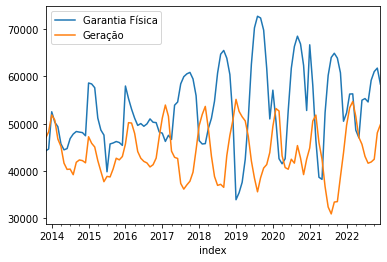

In [3]:
df.plot()

In [28]:
class LSTM:
    def __init__(self,main_serie,extra_series):
        self.last = main_serie.values[-1]
        self.data = TimeSeries.from_dataframe(main_serie)
        self.extra_data = TimeSeries.from_dataframe(extra_series)
        self.scaler_y = Scaler()
        self.transformed_data = self.scaler_y.fit_transform(self.data)
        self.scaler_x = Scaler()
        self.transformed_extra_data = self.scaler_x.fit_transform(self.extra_data)
    def fit(self,input_size,output_size):
        self.model_cov = BlockRNNModel(
            model = "LSTM",
            input_chunk_length = input_size,
            output_chunk_length = output_size,
            n_epochs = 300,
        )
        self.model_cov.fit(
            series = self.transformed_data,
            past_covariates = self.transformed_extra_data,
            verbose = False,
        )
        return self
    def predict(self,n):
        prediction = self.model_cov.predict(n = n,series = self.transformed_data, past_covariates = self.transformed_extra_data)
        converted_prediction = self.scaler_y.inverse_transform(prediction).values().ravel()
        difference = converted_prediction[0] - self.last
        prediction_final = converted_prediction - difference
        return prediction_final

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<AxesSubplot:xlabel='index'>

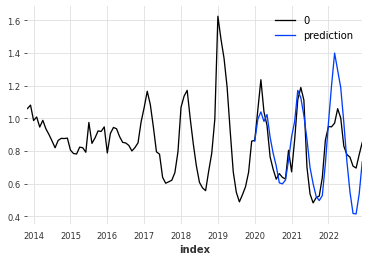

In [34]:
steps = 36
y_train = (df['Geração'] / df['Garantia Física']).iloc[:-steps].to_frame()
model = LSTM(y_train,df.iloc[:-steps]).fit(24,steps)
y_pred = model.predict(steps)
pred_df = (df['Geração'] / df['Garantia Física']).to_frame()
pred_df['prediction'] = [None for i in range(len(y_train))] + list(y_pred)
pred_df.plot()